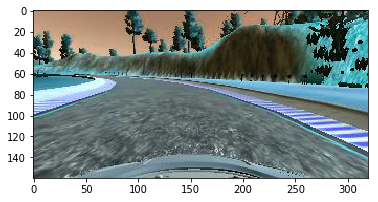

In [1]:
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_db(dir):
    with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
        reader = csv.reader(f)
        data = [row for row in reader]
        res = np.asarray(data)
        c, l, r, st, t, b, sp = np.split(res, 7, axis=1)
        c = np.array([cv2.imread(p) for p in c.squeeze()])
        return c, st.squeeze()
        
c, st = process_db('../kb1')
%matplotlib inline
plt.imshow(c[20])

        

In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

c, st = shuffle(c, st)
st = st.astype(np.float32)
# conds = [[st<0], [st==0], [st>0]]
# select_c = c[conds[0]][:2]
# select_st = st[conds[0]][:2]
# for cond in conds: 
#     select_c = np.append(select_c, c[cond][:2], axis=0)
#     select_st = np.append(select_st, st[cond][:2], axis=0)
# print(select_c.shape, c.shape)

# print(select_st.shape, st.shape)
X_train, X_valid, y_train, y_valid = train_test_split(c[:20], st[:20], test_size=0.20)
print(y_train)



[ 0.          0.          0.          0.          0.         -0.214635    0.
  0.          0.          0.          0.          0.         -0.2443829
 -0.04317302  0.          0.        ]


In [25]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.wrappers.scikit_learn import KerasRegressor

from keras.layers.pooling import MaxPooling2D
import numpy as np
from random import random

model = Sequential()
# model.add(Convolution2D(128, 5, 5, border_mode='same', activation='relu', input_shape=(160, 320, 3)))
# model.add(MaxPooling2D((2,2)))
# model.add(Convolution2D(256, 5, 5, border_mode='same', activation='relu'))
# model.add(MaxPooling2D((2,2)))
# model.add(Convolution2D(512, 5, 5, border_mode='same', activation='relu'))
# model.add(MaxPooling2D((2,2)))

X_fake = np.array([[2, 3],[3, 2],[2, 2], [1,3], [1,2], [5,5], [10, 11]])
#X_fake = np.reshape(X_fake, (5,2,1))
y_fake = np.array([13, 13, 8, 10, 5, 50, 221])
#y_fake = np.reshape(y_fake, (5,1,1))

a = np.reshape([int(random()*10) for i in range(100)], (-1, 1))
b = np.reshape([int(random()*10) for i in range(100)], (-1, 1))
X_fake = np.append(a,b,axis=1)
y_fake = a*a + b*b

print(a.shape, b.shape, X_fake.shape, y_fake.shape)
print(X_fake[:3], y_fake[:3])

#model.add(Flatten(input_shape=(2,1)))
model.add(Dense(256, name='d1',activation='relu', input_dim=2))
model.add(Dense(128, name='d2',activation='linear'))
model.add(Dense(64, name='d3',activation='relu'))
model.add(Dense(1, name='d4', activation='linear'))


model.compile('adam', 'mse', ['mse'])
#history = model.fit(X_train, y_train, batch_size=128, nb_epoch=2, verbose=1, validation_data=(X_valid, y_valid))
history = model.fit(X_fake, y_fake, nb_epoch=20, verbose=1)
X_pred = np.array([[5,5]])
model.predict(X_pred)






(100, 1) (100, 1) (100, 2) (100, 1)
[[2 2]
 [9 3]
 [2 6]] [[ 8]
 [90]
 [40]]
Epoch 1/20
10/10 [==============================] - 0s - loss: 7464.3633 - mean_squared_error: 7464.3633
Epoch 2/20
10/10 [==============================] - 0s - loss: 7265.0830 - mean_squared_error: 7265.0830
Epoch 3/20
10/10 [==============================] - 0s - loss: 7101.0713 - mean_squared_error: 7101.0713
Epoch 4/20
10/10 [==============================] - 0s - loss: 6926.1968 - mean_squared_error: 6926.1968
Epoch 5/20
10/10 [==============================] - 0s - loss: 6737.4702 - mean_squared_error: 6737.4702
Epoch 6/20
10/10 [==============================] - 0s - loss: 6533.3770 - mean_squared_error: 6533.3770
Epoch 7/20
10/10 [==============================] - 0s - loss: 6314.9082 - mean_squared_error: 6314.9082
Epoch 8/20
10/10 [==============================] - 0s - loss: 6081.6792 - mean_squared_error: 6081.6792
Epoch 9/20
10/10 [==============================] - 0s - loss: 5831.9365 - mean_squ

array([[ 39.08863831]], dtype=float32)